In [1]:
!pip install wand
!apt install imagemagick
!pip install myqlm
!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 KB 4.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texliv

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$
With $(i,j)$ an edge connecting vertex i and j.
Minimizing H means having the most $ -1 $ in the sum hence miximising the number of edges which connect opposite spins. 

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [2]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:

    # Assuming b is one configuration
    val = 0
    for edge in edges:
      val = val + (1 if b[edge[0]]==b[edge[1]] else -1)
      # Compute the energy associated to b
    
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

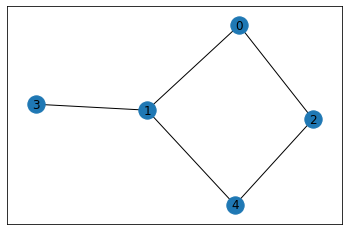

In [3]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [4]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [5]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [6]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    #First RX on every qbits with angle theta
    for i in range(n_qubits):
      layer.apply(RX(theta), i)
    #Then apply exp(-i Beta Hc)
    #One can separate exp into a product of exponential since sigmai*sigmaj commutes.
    for edge in edges:
      layer.apply(U_ZZ(beta), edge[0], edge[1])
    
    return layer

### Question 4

In [9]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit

    #init phase (tower of Hadamard)
    for i in range(n_qubits):
      prog.apply(H, qubits[i])

    # apply the layers
    for p in range(n_layers):
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[2*p], parameters[2*p + 1]), qubits)
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # int(sample.state.bitstring[i]) contains the qubit values
        # sample.probability the probability of getting the state
        contribution = 0
        for edge in edges:
          contribution = contribution + (1 if sample.state.bitstring[edge[0]] == sample.state.bitstring[edge[1]] else -1)
        obs = obs + sample.probability*contribution

    # END TODO
    return obs
    
        

In [10]:
import numpy as np
np.random.random(3)

array([0.1393448 , 0.16521417, 0.02068841])

In [11]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question: 8 environ

-0.0653933446757361 -0.728594172716611 -1.353832710415996 -1.5706752234434571 -1.9608644269251223 -3.5706016610348787 -3.691573753266374 -3.7380390831989647 -3.7667402949869815 -3.7998987695481525 -3.8194658891998694 -4.0138427890947055 -4.0406710471133245 -4.09110005762796 -4.178551319115422 -4.231720778665656 -4.242212142347899 -4.261789074674092 -4.2952753084155715 -4.327283023916141 -4.3810211964255545 -4.460216700099359 -4.48937844474335 -4.498796330004911 -4.501648542790144 -4.504045048430268 -4.508267031315327 -4.5153086970353336 -4.521846594221539 -4.524270624891723 -4.524741783905333 -4.5247739338300486 -4.524777402806409 -4.5247801948066515 -4.524781310540866 -4.524781364461514 -4.524781365761203 -4.524781365780594 6
-0.0012216636643493164 -0.6195945650258529 -1.0956501923752566 -2.670177610387618 -2.874197871693744 -3.193231712446146 -3.5743169012621685 -4.24776041256205 -4.369461514260577 -4.404082423194511 -4.4351331950612085 -4.483076122955211 -4.553055891546205 -4.583937

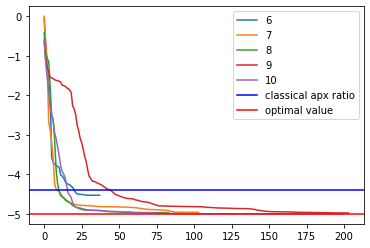

In [14]:
import matplotlib.pylab as plt


for nlayers in range(6,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    print(nlayers)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

#8 layers seem to be enough

### Question 6: smart initialization

$ H(\frac{k}{p} T)\frac{T}{p} = ((1-\frac{k}{p}T \frac{1}{T})\sum_{k}{\sigma _{x} ^{k}} + \frac{k}{p}T \frac{1}{T} H_c)\frac{T}{p} = (1-\frac{k}{p}) \frac{T}{p}\sum_{k}{\sigma _{x} ^{k}} + \frac{k}{p} \frac{T}{p} H_c$
<br/>
We fix p = nlayers.
<br/>
$ \theta _k = (1-\frac{k}{p})\frac{T}{p} $ and $ \beta _k = \frac {k}{p}\frac{T}{p} $ with k going from 1 to p.

One notices that the curves decrease faster. The optimal value for the number of parameter is reached more rapidly for the smart initialization.
For small T it converges faster than for high values of T.

-8.101682124325715e-05 -1.5449260827383722 -2.4209419513789108 -2.4210028090708584 -2.5799624408825084 -2.857854041715631 -3.1289726846950012 -3.1884667219619067 -3.196461490111761 -3.197917602565196 -3.2005852027291217 -3.205404697485715 -3.213464905006102 -3.222874095708079 -3.2248660236779596 -3.226047235881934 -3.226069070337021 -3.2260696437063086 -3.226069647207668 -3.2260696472309895 3
-5.899317738852772e-05 -2.1856829073475037 -2.1857380267009625 -2.3189825650529188 -2.5597560900048473 -2.781728768274743 -3.1060438610395615 -3.665181702804994 -4.151821749467713 -4.326435615711672 -4.4082167937285215 -4.446842389276301 -4.461331110212986 -4.46328357590295 -4.463780240476473 -4.463808036085563 -4.463828447821802 -4.463832372921013 -4.463832626764446 -4.4638326322676605 -4.463832632304969 4
-5.239994542416415e-05 -2.43354926628051 -2.4336018829542687 -2.5647558516787896 -3.729288192542632 -3.7724066073399376 -3.8525174667667246 -3.9930539483389906 -4.12215472261747 -4.184239428226

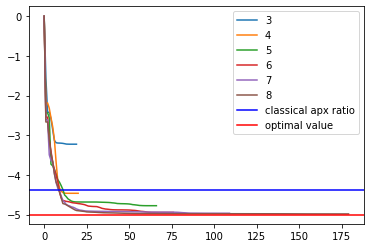

In [17]:
T = 0.01

for nlayers in range(3,9,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for i in range(nlayers):
      beta = (i+1)/nlayers*T/nlayers
      theta = (1-(i+1)/nlayers)*T/nlayers
      parameters_init.append(theta)
      parameters_init.append(beta)
    # END TODO       
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    print(nlayers)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()